<a href="https://colab.research.google.com/github/carlangastr/marketing-science-projects/blob/main/Marketing_Mix_Modeling_%5BLinkedin_Article%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!DOCTYPE html>
<html>
<body>

<!-- Exploratory data analisys header -->

<h2>Bayes Marketing Mix Modeling 🪲</h2>
<ul>
<li style="text-align: left;"><sub><strong>Client</strong>: Test [Data]</sub></li>
<li style="text-align: left;"><sub><strong>Author</strong>: Carlos Trujillo</sub></li>
<li style="text-align: left;"><sub><strong>Project id</strong>: 01CTEDA22</sub></li>
</ul>

</body>
</html>

In [ ]:
!pip install arviz==0.11.4 pymc3 optuna prophet scikit-misc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing libraries pandas, numpy, plotly, and seaborn

import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
import re

#Importing modeling libraries
#Importing modeling libraries
from scipy.stats.mstats import mquantiles
import theano.tensor as tt
import theano
import pymc3 as pm
from prophet import Prophet
from scipy import optimize
import python_utils as utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils.validation import check_is_fitted, check_array
from scipy.signal import convolve2d
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from optuna.integration import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution
import arviz as az

In [ ]:
%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)
plt.rcParams['font.size'] = 18

In [ ]:
pd.options.plotting.backend = "plotly"

In [ ]:
facebook = pd.read_csv('/content/drive/MyDrive/Bayesian MMM/facebook.csv')
google = pd.read_csv('/content/drive/MyDrive/Bayesian MMM/google.csv')
sales = pd.read_csv('/content/drive/MyDrive/Bayesian MMM/sales_last_three_years.csv')

weather = pd.concat([pd.read_csv('/content/drive/MyDrive/Bayesian MMM/weather_estonia_18-20.csv'),pd.read_csv('/content/drive/MyDrive/Bayesian MMM/weather_estonia_20-22.csv')])

economics_21 = pd.DataFrame({'GDP per capita (current US$)': {0: 19700},
 'Inflation, consumer prices (annual %)': {0: 5.0},
 'Labor force, total': {0: 935981},             
 'Primary income payments (BoP, current US$)': {0: 1696860291.0},
 'date': {0: '2021-12-31'}})
economics_21['avg salary'] = economics_21['Primary income payments (BoP, current US$)']/economics_21['Labor force, total']

economics = pd.concat([economics_21, pd.read_csv('/content/drive/MyDrive/Bayesian MMM/estonia_control_economics_data.csv')])
economics = economics[['date','GDP per capita (current US$)','Inflation, consumer prices (annual %)','Labor force, total','Primary income payments (BoP, current US$)', 'avg salary']].reset_index(drop=True).loc[:3]
economics['country'] = 'Estonia'

In [ ]:
weather_frame = weather[['datetime', 'tempmax', 'tempmin', 'temp', 'solarenergy', 'humidity', 'precip']]
weather_frame.columns = ['date', 'tempmax', 'tempmin', 'temp', 'solarenergy', 'humidity', 'precip']

In [ ]:
temp = economics.copy()
temp.index = pd.to_datetime(temp.date)

empty = pd.DataFrame()

for paises in list(temp.country.value_counts().index):
  val = temp[temp.country == paises]
  del val['country']
  del val['date']
  temp_reindexed = val.resample('D').interpolate('slinear')
  temp_reindexed['country'] = paises

  temp_reindexed.rename(columns = {'GDP per capita (current US$)': 'gdp_per_capita_daily',
                                   'Inflation, consumer prices (annual %)': 'inflation_percentual',
                                   'Labor force, total': 'labor_force_total',
                                   'Primary income payments (BoP, current US$)': 'primary_income_payments',
                                   'avg salary': 'avg_salary'}, inplace = True)
  
  bix = (temp_reindexed.groupby(['country']).gdp_per_capita_daily.diff())
  bix = temp_reindexed.assign(gdp_per_capita_daily_ac = bix)
  delt = bix.copy()

  bix = (delt.groupby(['country']).inflation_percentual.diff())
  bix = delt.assign(inflation_percentual_ac = bix)
  delt = bix.copy()

  bix = (delt.groupby(['country']).labor_force_total.diff())
  bix = delt.assign(labor_force_total_ac = bix)
  delt = bix.copy()

  bix = (delt.groupby(['country']).primary_income_payments.diff())
  bix = delt.assign(primary_income_payments_ac = bix)
  delt = bix.copy()

  bix = (delt.groupby(['country']).avg_salary.diff())
  bix = delt.assign(avg_salary_ac = bix)
  delt = bix.copy()

  empty = pd.concat([empty, bix])

empty.tail()

In [ ]:
economics_modify = empty[['gdp_per_capita_daily',	'inflation_percentual',	'labor_force_total',	'primary_income_payments',	'avg_salary',	'country']].reset_index()
economics_modify['date'] = economics_modify['date'].astype(str)
economics_modify

In [ ]:
facebook.columns = ['date','facebook_impressions', 'facebook']
google.columns = ['date','google', 'google_impressions']
sales_fill = sales[['date', 'sales']].copy()

In [ ]:
#First print the len of analytics,
#Second, delete all the rows with missing values in all the columns of the dataframe
#Third, replace the missing values of a column with 0
#Fourth, show the first 5 rows of the dataframe
#Five, print the len of the dataframe with a formatted string

print('the len of the dataframe is {}'.format(len(sales_fill)))
sales_fill.dropna(inplace=True, axis=1, how='all')
sales_fill.fillna(0, inplace=True)
print('the len of the dataframe is {}'.format(len(sales_fill)))

the len of the dataframe is 1548
the len of the dataframe is 1548


In [ ]:
#First print the len of analytics,
#Second, delete all the rows with missing values in all the columns of the dataframe
#Third, replace the missing values of a column with 0
#Fourth, show the first 5 rows of the dataframe
#Five, print the len of the dataframe with a formatted string

print('the len of the dataframe is {}'.format(len(facebook)))
facebook.dropna(inplace=True, axis=1, how='all')
facebook.fillna(0, inplace=True)
print('the len of the dataframe is {}'.format(len(facebook)))

the len of the dataframe is 1551
the len of the dataframe is 1551


In [ ]:
#First print the len of analytics,
#Second, delete all the rows with missing values in all the columns of the dataframe
#Third, replace the missing values of a column with 0
#Fourth, show the first 5 rows of the dataframe
#Five, print the len of the dataframe with a formatted string

print('the len of the dataframe is {}'.format(len(google)))
google.dropna(inplace=True, axis=1, how='all')
google.fillna(0, inplace=True)
print('the len of the dataframe is {}'.format(len(google)))

the len of the dataframe is 1566
the len of the dataframe is 1566


In [ ]:
merge = pd.merge(sales_fill, facebook, on='date', how = 'left').merge(google, on='date', how = 'left').merge(economics_modify, on='date', how = 'left').merge(weather_frame, on='date', how = 'left')
merge.head(5)

In [ ]:
merge['date_week'] = pd.to_datetime(merge.date).dt.to_period('W').dt.start_time
merge.head(5)

In [ ]:
group = merge.groupby('date_week').agg({'sales':'sum', 'facebook_impressions':'sum',
                                        'facebook':'sum', 'google_impressions': 'sum', 
                                        'google': 'sum', 'gdp_per_capita_daily': 'mean',
                                        'inflation_percentual':'mean', 'labor_force_total': 'mean',
                                        'primary_income_payments': 'mean', 'avg_salary': 'mean', 
                                        'tempmax': 'mean', 'tempmin': 'mean', 'temp': 'mean',
                                        'solarenergy': 'mean', 'humidity':'mean', 'precip': 'mean'})
group.head(5)

In [ ]:
filtered = group[(group.sales > 0) & (group.facebook > 0) & (group.google > 0) & (group.index < '2022-01-01')]
filtered

In [ ]:
filtered.to_csv('data_filtered.csv')

In [ ]:
filtered.drop(columns=['sales']).plot()

In [ ]:
fig = px.imshow(filtered.corr())
fig.show()

In [ ]:
lag_periods =  4

def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

In [ ]:
for lags in range(lag_periods):
  print('The correlation between Transactions and Google, with a lag of {} days is {}'.format(lags,crosscorr(filtered['sales'], filtered['google'], lag = lags)))

The correlation between Transactions and Google, with a lag of 0 days is 0.480120487809493
The correlation between Transactions and Google, with a lag of 1 days is 0.46313502927455324
The correlation between Transactions and Google, with a lag of 2 days is 0.4611542536550129
The correlation between Transactions and Google, with a lag of 3 days is 0.45875580001224936


In [ ]:
for lags in range(lag_periods):
  print('The correlation between Transactions and Facebook, with a lag of {} days is {}'.format(lags,crosscorr(filtered['sales'], filtered['facebook'], lag = lags)))

The correlation between Transactions and Facebook, with a lag of 0 days is 0.6002278992450638
The correlation between Transactions and Facebook, with a lag of 1 days is 0.6022209582605829
The correlation between Transactions and Facebook, with a lag of 2 days is 0.6031105684534523
The correlation between Transactions and Facebook, with a lag of 3 days is 0.5822595159995573


In [ ]:
def adstock_geometric(x: float, alpha: float):
  x_decayed = np.zeros_like(x)
  x_decayed[0] = x[0]
  for xi in range(1, len(x_decayed)):
    x_decayed[xi] = x[xi] + alpha* x_decayed[xi - 1]
  return x_decayed

def adstock_geometric_theano_pymc3(x, theta):
    x = tt.as_tensor_variable(x)
    
    def adstock_geometric_recurrence_theano(index, 
                                            input_x, 
                                            decay_x,   
                                            theta):
        return tt.set_subtensor(decay_x[index], 
               tt.sum(input_x + theta * decay_x[index - 1]))
    len_observed = x.shape[0]
    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])
    output, _ = theano.scan(
        fn = adstock_geometric_recurrence_theano, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]

def saturation_hill_pymc3(x, alpha, gamma): 
    x_s_hill = x ** alpha / (x ** alpha + gamma ** alpha)
    return x_s_hill

In [ ]:
data_prophet = filtered.reset_index()
prophet_data = data_prophet.rename(columns = {'sales': 'y', 'date_week': 'ds'})
#add categorical into prophet
#prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet = Prophet(yearly_seasonality=True,weekly_seasonality=True)
prophet.add_regressor(name = "facebook")
prophet.add_regressor(name = "google")
prophet.fit(prophet_data[["ds", "y", "facebook", "google"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "facebook", "google"]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet.plot_components(prophet_predict)

In [ ]:
prophet.plot(prophet_predict)

In [ ]:
#prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
#events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)
final_data = data_prophet.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]

In [ ]:
#define the function
START_ANALYSIS_INDEX = 0
END_ANALYSIS_INDEX = 150

spend_to_exposure_menten_func = lambda spend, V_max, K_m: V_max * spend / (K_m + spend)
media_exposures = ["facebook_impressions", "google_impressions"]
media_spends = ["facebook", "google"]
media_spend_exposure_df = pd.DataFrame()
for (media_exposure, media_spend) in zip(media_exposures, media_spends):
    V_max = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX].max()
    K_m   = V_max / 2
    spend = final_data[media_spend].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    exposure = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    best_values, _ = optimize.curve_fit(f = spend_to_exposure_menten_func, xdata = spend, ydata = exposure, p0 = [V_max, K_m])
    media_spend_exposure_df = pd.concat([media_spend_exposure_df, pd.DataFrame({'spend': [media_spend], 'exposure': [media_exposure], 'V_max': [best_values[0]], 'K_m': [best_values[1]]})]).reset_index(drop = True)
    
media_spend_exposure_df

,spend,exposure,V_max,K_m
0,facebook,facebook_impressions,4039031.76141,6409.37736
1,google,google_impressions,9318446.05188,20843.12876


In [ ]:
data = final_data.copy()
transform_variables = ['facebook_impressions', 'facebook',
       'google_impressions', 'google', 'gdp_per_capita_daily',
       'inflation_percentual', 'labor_force_total', 'primary_income_payments',
       'avg_salary', 'tempmax', 'tempmin', 'temp', 'solarenergy', 'humidity',
       'precip', 'trend', 'season']
delay_channels = ["google_impressions", "facebook_impressions"]
media_channels = ["google_impressions", "facebook_impressions"]
control_variables = ['gdp_per_capita_daily',
       'inflation_percentual', 'labor_force_total', 'primary_income_payments',
       'avg_salary', 'tempmax', 'tempmin', 'temp', 'solarenergy', 'humidity',
       'precip', 'trend', 'season']
target = "sales"

In [ ]:
data_transformed = data.copy()
numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scalerdependent_transformation = None
original = data[target].values
data_transformed[target] = original / 100_000

In [ ]:
dependent_transformation = MinMaxScaler()
original = data[target].values.reshape(-1, 1)
transformed = dependent_transformation.fit_transform(original)
data_transformed[target] = transformed

In [ ]:
response_mean = []
with pm.Model() as model_2:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 3)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    intercept = pm.Normal("intercept", np.mean(data_transformed[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])

Delay Channels: Adding google_impressions


INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:Compiling new CVM
INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:New version 0.211


Delay Channels: Adding facebook_impressions
Control Variables: Adding gdp_per_capita_daily
Control Variables: Adding inflation_percentual
Control Variables: Adding labor_force_total
Control Variables: Adding primary_income_payments
Control Variables: Adding avg_salary
Control Variables: Adding tempmax
Control Variables: Adding tempmin
Control Variables: Adding temp
Control Variables: Adding solarenergy
Control Variables: Adding humidity
Control Variables: Adding precip
Control Variables: Adding trend
Control Variables: Adding season


In [ ]:
with model_2:
    trace = pm.sample(tune=1000, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)
trace_summary

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [sigma, intercept, season_control_coef, trend_control_coef, precip_control_coef, humidity_control_coef, solarenergy_control_coef, temp_control_coef, tempmin_control_coef, tempmax_control_coef, avg_salary_control_coef, primary_income_payments_control_coef, labor_force_total_control_coef, inflation_percentual_control_coef, gdp_per_capita_daily_control_coef, facebook_impressions_media_coef, facebook_impressions_alpha, facebook_impressions_gamma, facebook_impressions_adstock, google_impressions_media_coef, google_impressions_alpha, google_impressions_gamma, google_impressions_adstock]
INFO:pymc3:NUTS: [sigma, intercept, season_control_coef, trend_control_coef, precip_control_coef, humidity_control_coef, solarenergy_control_

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20139 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20139 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gdp_per_capita_daily_control_coef,-0.42200,2.31000,-4.81500,3.68400,0.11700,0.08300,389.00000,715.00000,1.00000
inflation_percentual_control_coef,-0.47000,1.82700,-4.09700,2.68400,0.08200,0.05800,496.00000,761.00000,1.01000
labor_force_total_control_coef,-0.68200,2.34300,-4.86500,4.09700,0.09800,0.06900,572.00000,750.00000,1.01000
primary_income_payments_control_coef,0.67000,1.98300,-3.16200,4.27500,0.08500,0.06000,543.00000,806.00000,1.01000
avg_salary_control_coef,0.20700,2.54500,-4.70200,5.05300,0.09900,0.07000,664.00000,896.00000,1.00000
tempmax_control_coef,0.50700,0.52900,-0.45800,1.55400,0.02700,0.01900,375.00000,660.00000,1.01000
tempmin_control_coef,-0.14200,0.47000,-1.07300,0.70400,0.02500,0.01700,368.00000,633.00000,1.01000
temp_control_coef,-0.31600,0.94900,-2.08500,1.55600,0.05300,0.03800,318.00000,581.00000,1.01000
solarenergy_control_coef,0.07000,0.08500,-0.08700,0.22200,0.00400,0.00300,381.00000,870.00000,1.01000
humidity_control_coef,0.07200,0.07500,-0.08300,0.20000,0.00300,0.00200,581.00000,1142.00000,1.01000


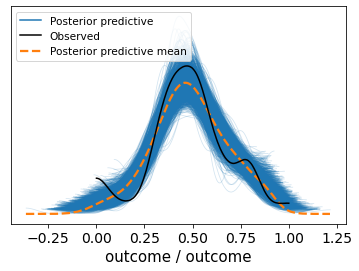

In [ ]:
with model_2:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_2), var_names = ["outcome"])

In [ ]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

In [ ]:
az.plot_joint(
    trace,
    var_names=['facebook_impressions_media_coef', 'facebook_impressions_adstock'],
)

In [ ]:
az.plot_joint(
    trace,
    var_names=['facebook_impressions_adstock', 'facebook_impressions_alpha'],
)

In [ ]:
az.plot_joint(
    trace,
    var_names=['facebook_impressions_media_coef', 'trend_control_coef'],
)

In [ ]:
az.plot_joint(
    trace,
    var_names=['facebook_impressions_gamma', 'facebook_impressions_alpha'],
)

In [ ]:
with model_2:
    posterior = pm.sample_posterior_predictive(trace)
posterior['outcome'].mean()

0.4890607926009896

In [ ]:
az.plot_trace(trace)

In [ ]:
def nrmse(y_true, y_pred):
   return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
#restore the original revenue by multiplying back 100K
y_pred = ppc_all["outcome"].mean(axis = 0) * 100_000
print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")

RMSE: 700813.0923435014
MAPE: 0.9328251111074303
NRMSE: 0.6117382471077132


In [ ]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    mean_variable = ppc_all[variable].mean()
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)

print(np.sqrt(np.mean((y_true - y_pred)**2)))
print(np.mean(np.abs((y_true - y_pred) / y_true)))
print(nrmse(y_true, y_pred))

93074.25052207168
0.11382598530427479
0.08124431390806373


In [ ]:
X = data_transformed.drop(columns=['sales'])
y = data_transformed['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

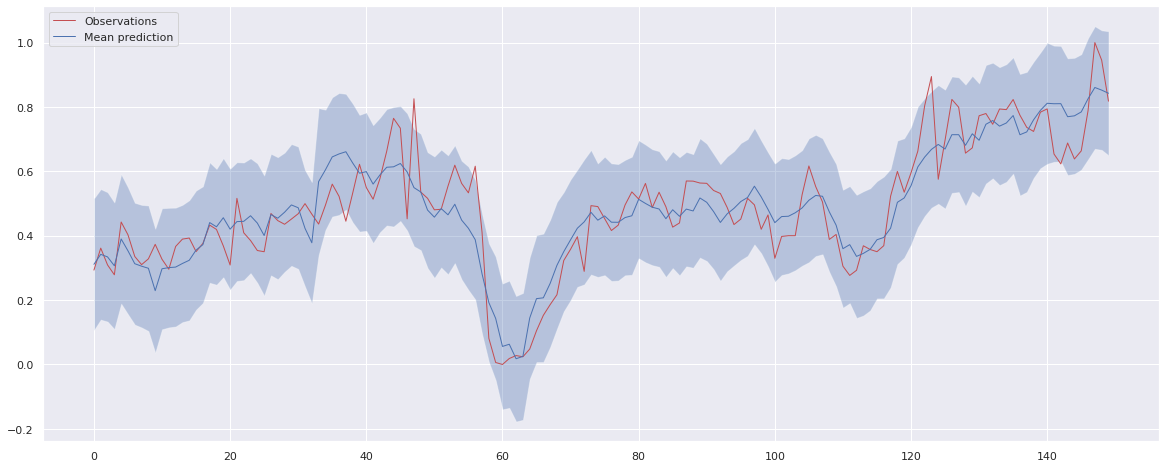

In [ ]:
means = posterior['outcome'].mean(0)
stds = posterior['outcome'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y.values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], linewidth=1, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

In [ ]:
def plot_residuals(actual_vs_predicted: pd.DataFrame, figure_size = (15, 10)):
    """Residual plot

    Args:
        actual_vs_predicted (pd.DataFrame): Data Frame with three columns: date, actual, predicted
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).
    """
    
    plt = ggplot(actual_vs_predicted, aes("predicted", y = "actual - predicted"))\
    + geom_point(size = 2, show_legend = True)\
    + geom_hline(yintercept = 0, linetype = "dashed")\
    + geom_smooth(se=True, method = "loess", color = "blue")\
    + ggtitle("Actuals vs. predicted response") + xlab("predicted") + ylab("residual")\
    + theme(figure_size = figure_size,
                        legend_direction='horizontal', 
                        legend_position= "bottom",
                        legend_box_spacing=0.5,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
        ) 
    
    return plt

plot = plot_residuals(pd.DataFrame({"actual": y_true, "predicted": y_pred}), figure_size = (15, 5))
plot

In [ ]:
exposure_to_spend_menten_func = lambda exposure, V_max, K_m: exposure * K_m / (V_max - exposure)
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)
    spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

In [ ]:
data_transformed_decomposed = data_transformed.copy()
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df

,media,total_effect,effect_share
0,google_impressions,25.44188,0.29797
1,facebook_impressions,59.94276,0.70203


In [ ]:


spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df



,media,total_spend,spend_share,total_effect,effect_share
0,google_impressions,361295.47629,0.34896,25.44188,0.29797
1,facebook_impressions,674068.17220,0.65104,59.94276,0.70203


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



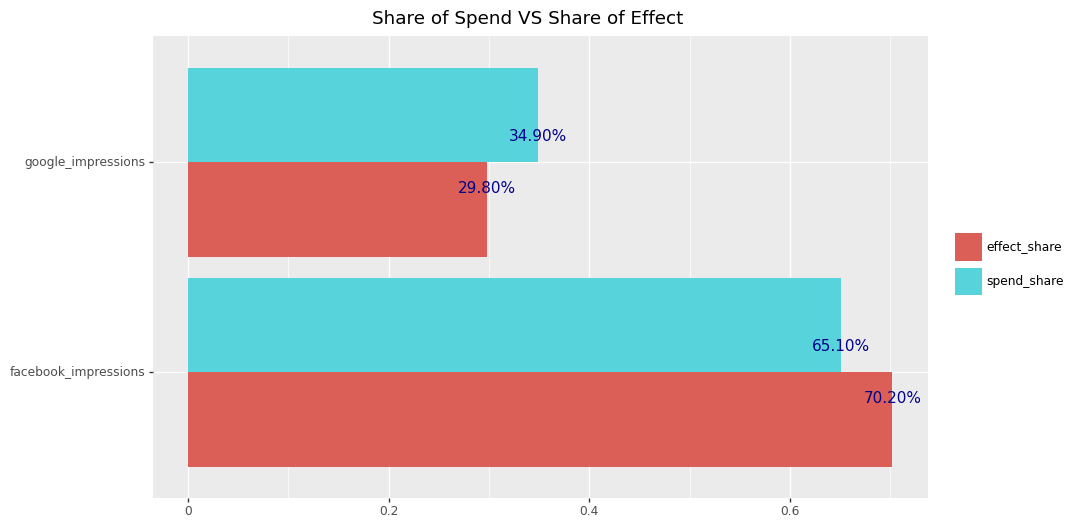

<ggplot: (8769115471577)>

In [ ]:
def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))

In [ ]:
adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))


In [ ]:
for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")

google_impressions
	adstock 0.910691389855212 transformation
	saturation alpha 3.8409247013207475, gamma 0.16067125593255646 transformation
	coefficient: 0.29851066453261704
facebook_impressions
	adstock 0.48430447439478796 transformation
	saturation alpha 2.8298620345001626, gamma 0.26947979333663785 transformation
	coefficient: 0.23648387895359582


In [ ]:
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef
    
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = dependent_transformation.inverse_transform(data_transformed_decomposed["prediction"].values.reshape(-1,1))[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].reshape(-1)

Intercept: -0.35624189359254776
Control Coefficient: gdp_per_capita_daily: -0.42223620382668453
Control Coefficient: inflation_percentual: -0.4699018672646347
Control Coefficient: labor_force_total: -0.6820023675528707
Control Coefficient: primary_income_payments: 0.669882590537984
Control Coefficient: avg_salary: 0.20662387638552338
Control Coefficient: tempmax: 0.5068756679670413
Control Coefficient: tempmin: -0.14171931778617228
Control Coefficient: temp: -0.3157304741183704
Control Coefficient: solarenergy: 0.06977230594917808
Control Coefficient: humidity: 0.07159785497165674
Control Coefficient: precip: 0.036041792754037585
Control Coefficient: trend: 1.491790753014884
Control Coefficient: season: 0.3336881589647412


In [ ]:
data_transformed_decomposed.to_csv('/content/drive/MyDrive/Bayesian MMM/data_transformed_decomposed.csv')

In [ ]:
data_example = data.loc[:149].copy()
data_example['predict'] = dependent_transformation.inverse_transform(posterior["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1) # y_pred_decomposed.copy()
data_example.head(5)

In [ ]:
contribution_frame = data_transformed_decomposed[['date_week','sales','facebook_impressions','google_impressions','prediction','intercept']].copy()
contribution_frame['sales'] = dependent_transformation.inverse_transform(contribution_frame['sales'].values.reshape(-1,1)).reshape(-1)
contribution_frame['facebook_impressions'] = dependent_transformation.inverse_transform(contribution_frame['facebook_impressions'].values.reshape(-1,1)).reshape(-1)
contribution_frame['google_impressions'] = dependent_transformation.inverse_transform(contribution_frame['google_impressions'].values.reshape(-1,1)).reshape(-1)
contribution_frame['prediction'] = dependent_transformation.inverse_transform(contribution_frame['prediction'].values.reshape(-1,1)).reshape(-1)
contribution_frame['intercept'] = dependent_transformation.inverse_transform(contribution_frame['intercept'].values.reshape(-1,1)).reshape(-1)
contribution_frame

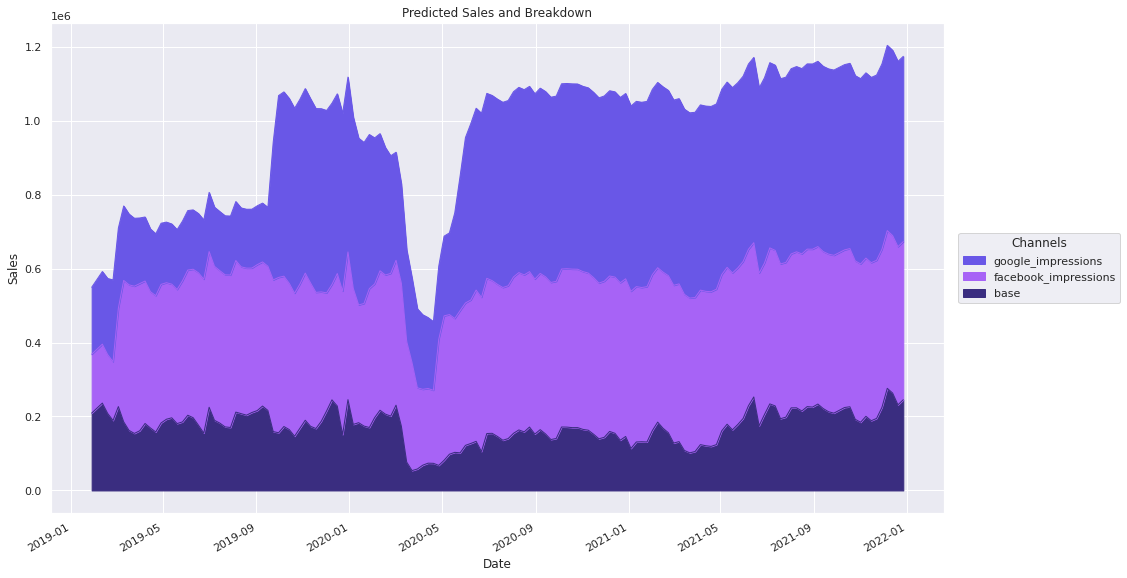

In [ ]:
adj_contributions = contribution_frame[['date_week', 'base', 'facebook_impressions', 'google_impressions']].copy()
adj_contributions.index = adj_contributions.date_week

pd.options.plotting.backend = "matplotlib"
sns.set_theme()
ax = (adj_contributions.drop(columns = ['date_week'])
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date',
          color={'base':'#3A2D80', 'facebook_impressions':'#A763F6', 'google_impressions':'#6957E7'}
          # cbar_kws={"#3A2D80": .5}
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [ ]:
#Buscar como utilizar mi intercepcion y verificar coeficientes + añadir el adstock y saturacion
contribution_frame.to_csv('/content/drive/MyDrive/Bayesian MMM/model_results.csv')
#data_example = pd.read_csv('model_results.csv')

In [ ]:
#data_transformed_decomposed.facebook * 100_000
corr = data_transformed_decomposed.corr()
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, 
            yticklabels = corr.columns, annot = True, 
            cmap = sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, 
            yticklabels = corr.columns, annot = True, 
            cmap = sns.diverging_palette(220, 20, as_cmap=True))